In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class RBFLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, centers=None):
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centers = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.log_beta = torch.nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters(centers)

    def reset_parameters(self, centers):
        if centers is not None:
            self.centers.data = centers
        else:
            torch.nn.init.kaiming_uniform_(self.centers, a=5)
        torch.nn.init.constant_(self.log_beta, 0)

    # 用模型预测x值
    def forward(self, x):
        size = (x.size(0), self.out_features, self.in_features)
        x = x.unsqueeze(1).expand(size)
        c = self.centers.unsqueeze(0).expand(size)
        beta = torch.exp(-self.log_beta).unsqueeze(0).expand(size[:2])
        return beta * torch.norm(x - c, dim=2)

In [3]:
class RBFNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, centers=None, *args, **kwargs):
        super(RBFNetwork, self).__init__()
        self.rbf = RBFLayer(in_features, hidden_features, centers)
        self.linear = torch.nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.rbf(x)
        x = torch.exp(-x)
        x = self.linear(x)
        return x

In [4]:
# 生成正弦波数据
np.random.seed(0)
x = torch.linspace(-3, 3, 100).view(-1, 1)
y = torch.sin(x) + torch.tensor(np.random.normal(0, 0.1, x.size())).float()

In [5]:
# 创建和训练RBF网络
rbfnet = RBFNetwork(1, 10, 1)
optimizer = torch.optim.Adam(rbfnet.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

In [6]:
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = rbfnet(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

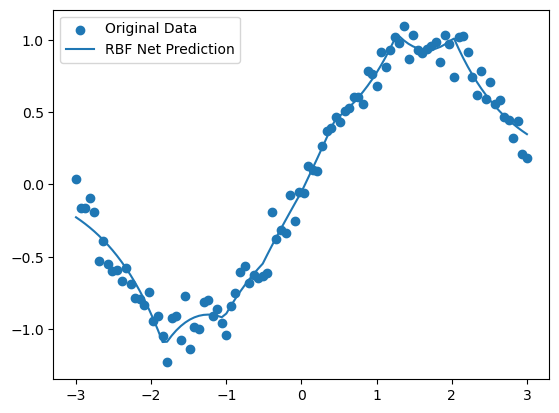

In [7]:
# 绘制原始数据和RBF网络的预测
plt.scatter(x.detach().numpy(), y.detach().numpy(), label='Original Data')
plt.plot(x.detach().numpy(), rbfnet(x).detach().numpy(), label='RBF Net Prediction')
plt.legend()
plt.show()